### Plan:
running detection model with low confidence threshold (0.3)

getting rid of detections other than ball under confidence threshhold (0.6)


running tracking models on it


converting to cvat format

adding missing ball detections manually with cvat (+ fixing other detection and tracking results)

exporting the annotations

processing results: team detection + ball possession

plotting the tracking data on the video

In [ ]:
import time
import numpy as np
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Deep-Sort Code

In [ ]:
from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from tools import generate_detections as gdet

In [ ]:
def convert_boxes(image, boxes):
    returned_boxes = []
    for box in boxes:
        box[0] = (box[0] * image.shape[1]).astype(int)
        box[1] = (box[1] * image.shape[0]).astype(int)
        box[2] = (box[2] * image.shape[1]).astype(int)
        box[3] = (box[3] * image.shape[0]).astype(int)
        box[2] = int(box[2]-box[0])
        box[3] = int(box[3]-box[1])
        box = box.astype(int)
        box = box.tolist()
        if box != [0,0,0,0]:
            returned_boxes.append(box)
    return returned_boxes

In [ ]:
max_cosine_distance = 0.5
nn_budget = None
nms_max_overlap = 0.8

model_filename = 'deep_sort/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename, batch_size=1)
metric = nn_matching.NearestNeighborDistanceMetric('cosine', max_cosine_distance, nn_budget)
tracker = Tracker(metric)

### Capture video

In [ ]:
vid = cv2.VideoCapture('./data/video/foot-5frames.mp4')

codec = cv2.VideoWriter_fourcc(*'mp4v')
vid_fps =int(vid.get(cv2.CAP_PROP_FPS))
vid_width,vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('./data/video/results-5frames.mp4', codec, vid_fps, (vid_width, vid_height))

### Tracking code

In [ ]:
all_frames_data = []
i=1
while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    frame_objects = []
    img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    t1 = time.time()

    boxes, scores, names= detect_fn(img)

    allowed_classes=['player']
    deleted_indx = []
    for j in range(len(boxes)):
        if not (names[j] in allowed_classes):
            deleted_indx.append(j)
    boxes = np.delete(boxes, deleted_indx, axis=0)
    names = np.delete(names, deleted_indx, axis=0)
    scores = np.delete(scores, deleted_indx, axis=0)

    i+=1

    converted_boxes = convert_boxes(img, boxes)
    features = encoder(img, converted_boxes)

    detections = [Detection(bbox, score, class_name, feature) for bbox, score, class_name, feature in
                   zip(converted_boxes, scores, names, features)]
    boxs = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    classes = np.array([d.class_name for d in detections])
    indices = preprocessing.non_max_suppression(boxs, classes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]
    tracker.predict()
    tracker.update(detections)

    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i)[:3] for i in np.linspace(0,1,20)]

    current_count = int(0)

    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update >1:
            continue

        bbox = track.to_tlbr()
        class_name= track.get_class()
        color = colors[int(track.track_id) % len(colors)]
        color = [i * 255 for i in color]

        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), 2)
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)
                    +len(str(track.track_id)))*17, int(bbox[1])), -1)
        cv2.putText(img, class_name+"-"+str(track.track_id), (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                    (255, 255, 255), 2)

        object_data = {
            "box": track.to_tlbr(),
            "id": track.track_id,
            "class": track.get_class()
        }

        frame_objects.append(object_data)

    all_frames_data.append(frame_objects)

    fps = 1./(time.time()-t1)
    cv2.putText(img, "FPS: {:.2f}".format(fps), (0,30), 0, 1, (0,0,255), 2)
    cv2.resizeWindow('output', 1024, 768)
    cv2.imshow('output', img)
    out.write(img)

    if cv2.waitKey(1) == ord('q'):
        break
vid.release()
out.release()
cv2.destroyAllWindows()

### Display video frames

In [ ]:
def display_video_frames(video_path):
    # Capture the video from the file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    frame_count = 0

    # Read until video is completed
    while cap.isOpened():
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret:
            frame_count += 1
            # Convert the frame from BGR (OpenCV default) to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(20,20))
            # Display the resulting frame
            plt.imshow(frame_rgb)
            plt.title(f"Frame {frame_count}")
            plt.axis('off')
            plt.show()

        else:
            break

    # Release the video capture object
    cap.release()

# Color filtering

### Clustering by average color of player region

In [ ]:
img=res
colors=[]
for i in range(len(frame)):
    object=frame[i]
    bbox=object['box']
    bbox_int = bbox.astype(int)
    # Extract each coordinate
    xmin, ymin, xmax, ymax = bbox_int
    # Extract the region of interest (ROI) using integer coordinates
    player_region = img[ymin:ymax, xmin:xmax]
    average_color = player_region.mean(axis=(0, 1))
    colors.append(average_color)
    plt.imshow(player_region)
    plt.show()
colors

In [ ]:
from sklearn.cluster import KMeans
# Assuming 'colors' is a list of average color values of players
# Each color is a list or array of [R, G, B] values
colors = np.array(colors)  # Convert to NumPy array for sklearn

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, n_init=10, random_state=0).fit(colors)
labels = kmeans.labels_  # Get cluster labels for each player

In [ ]:
for i in range(len(frame)):
    object=frame[i]
    label=labels[i]
    bbox=object['box']
    bbox_int = bbox.astype(int)
    # Extract each coordinate
    xmin, ymin, xmax, ymax = bbox_int
    # Extract the region of interest (ROI) using integer coordinates
    player_region = img[ymin:ymax, xmin:xmax]
    print(label)
    plt.imshow(player_region)
    plt.show()

### Applying color masks to filer green color of grass

In [ ]:
# Load the image
image = cv2.imread('/Users/fadijemmali/Desktop/Tracker/data/video/frames/image1.png')

# Convert to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define range of green color in HSV
lower_green = np.array([40,40, 40])
upper_green = np.array([70, 255, 255])

# Create a binary mask for green color
mask = cv2.inRange(hsv, lower_green, upper_green)

# Optional: Apply the mask to the image (setting green areas to black)
res = cv2.bitwise_and(image, image, mask=~mask)
res_bgr = cv2.cvtColor(res,cv2.COLOR_HSV2BGR)
res_gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
kernel = np.ones((13,13),np.uint8)
thresh = cv2.threshold(res_gray,127,255,cv2.THRESH_BINARY_INV |  cv2.THRESH_OTSU)[1]
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
# Now, when processing player regions, use the mask to exclude green areas
plt.imshow(res)
plt.show()

# Other utils

### Drawing circles under players

In [ ]:
# Function to draw an ellipse under detected objects
def draw_ellipse(image, box, color, thickness=4):
    x_min, y_min, x_max, y_max = box
    bottom_center = (int((x_min + x_max) / 2), int(y_max))
    axes = (int((x_max - x_min) / 2), int(0.35 * (x_max - x_min)))
    #cv2.ellipse(image, bottom_center, axes, 0, -45, 235, color, thickness, cv2.LINE_4)
    #cv2.ellipse(image, bottom_center, axes, 0, 0, 360, color, thickness)
    cv2.ellipse(
        image,
        center=bottom_center,
        axes=axes,
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
# Color definitions for different objects
COLORS = {
    "ball": (255, 255, 255),      # White
    "goalkeeper": (133, 1, 1),    # Dark Red
    "player": (0, 212, 187),      # Greenish
    "referee": (0, 255, 255)      # Yellow
}
THICKNESS = 4


for object in frame:
    box = object["box"]
    class_name = object["class"]
    color = COLORS.get(class_name, (0, 0, 255))  # Default to red if class not found
    draw_ellipse(img, box, color, THICKNESS)

# Display the frame
plt.imshow(img)
plt.show()

### Detecting ball possesion

In [ ]:
PLAYER_IN_POSSESSION_PROXIMITY = 30
MARKER_WIDTH = 10
MARKER_HEIGHT = 10
MARKER_MARGIN = 20
PLAYER_MARKER_COLOR = (0, 0, 255)  # Red in BGR
BALL_MARKER_COLOR = (0, 255, 0)  # Green in BGR
MARKER_CONTOUR_COLOR = (0, 0, 0)  # Black in BGR
MARKER_CONTOUR_THICKNESS = 1

def calculate_marker(anchor):
    x, y = anchor
    return np.array([
        [x - MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN],
        [x, y - MARKER_MARGIN],
        [x + MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN]
    ], np.int32)

def draw_marker(image, anchor, color):
    marker_contour = calculate_marker(anchor)
    cv2.fillPoly(image, [marker_contour], color)
    cv2.polylines(image, [marker_contour], isClosed=True, color=MARKER_CONTOUR_COLOR, thickness=MARKER_CONTOUR_THICKNESS)

def get_player_in_possession(players, ball):
    if len(ball) != 1:
        return None
    ball_x, ball_y = ball[0]['center']
    for player in players:
        player_x, player_y = player['center']
        if abs(player_x - ball_x) <= PLAYER_IN_POSSESSION_PROXIMITY and abs(player_y - ball_y) <= PLAYER_IN_POSSESSION_PROXIMITY:
            return player

for object in frame:
    x_min, y_min, x_max, y_max = object['box']
    object['center']=[(x_min+x_max)//2, (y_min+y_max)//2]

players = [det for det in frame if det['class'] == 'player']
ball = [det for det in frame if det['class'] == 'ball']
player_in_possession = get_player_in_possession(players, ball)
img2=img.copy()
if player_in_possession:
    draw_marker(img2, player_in_possession['center'], PLAYER_MARKER_COLOR)
for b in ball:
    draw_marker(img2, b['center'], BALL_MARKER_COLOR)
plt.figure(figsize=(20, 15))
plt.imshow(img2)
plt.axis('off')
plt.show()

# Getting detections from tensorflow model (Fast-RCNN)

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [ ]:
model_path='/Users/fadijemmali/Desktop/Tracker/faster_rcnn_inception_resnet_v2_1024x1024/export'
configs = config_util.get_configs_from_pipeline_file(os.path.join(model_path,'pipeline.config'))
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)

# Load the latest checkpoint
latest_ckpt = tf.train.latest_checkpoint(os.path.join(model_path,'checkpoint'))
if latest_ckpt:
    ckpt.restore(latest_ckpt).expect_partial()
    print(f"Checkpoint loaded: {latest_ckpt}")
else:
    raise FileNotFoundError("No checkpoint found in", os.path.join(model_path,'checkpoint'))

@tf.function
def rcnn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [ ]:
category_index ={1: {'id': 1, 'name': 'ball'},
                 2: {'id': 2, 'name': 'goalkeeper'},
                 3: {'id': 3, 'name': 'player'},
                 4: {'id': 4, 'name': 'referee'}}

In [ ]:
img = cv2.imread(IMAGE_PATH)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = rcnn(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
            for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes']+label_id_offset,
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          min_score_thresh=.6,
          agnostic_mode=False)
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
def detect_fn(img, threshold=0.1):
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = rcnn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1

    boxes = detections['detection_boxes']
    boxes = boxes[:, [1, 0, 3, 2]]  # Rearranging box coordinates
    scores = detections['detection_scores']
    classes = detections['detection_classes']

    ## Filter out detections with scores less than the threshold
    keep = scores > threshold
    boxes = boxes[keep]
    scores = scores[keep]
    classes = classes[keep]

    # Process class names
    class_names = [category_index[class_id + label_id_offset]['name'] for class_id in classes]

    return boxes, scores, class_names

# Funtion to detect player team color

In [ ]:
def count_nonblack_np(img):
    """Return the number of pixels in img that are not black.
    img must be a Numpy array with colour values along the last axis.

    """
    return img.any(axis=-1).sum()
def red(image):

    # Convert the image from BGR to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define lower and upper range of yellow in HSV
    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])

    mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)

    # Combine masks
    full_mask_red = cv2.bitwise_or(mask_red1, mask_red2)
    red_regions = cv2.bitwise_and(image, image, mask=full_mask_red)

    tot_pix = count_nonblack_np(image)
    color_pix = count_nonblack_np(red_regions)
    ratio = color_pix/tot_pix

    return ratio

def green(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 40, 40])  # Lower bound of light green
    upper_green = np.array([70, 255, 255])  # Upper bound of light green

    # Create masks for the yellow range
    mask_green = cv2.inRange(hsv_image, lower_green, upper_green)

    green_regions = cv2.bitwise_and(image, image, mask=mask_green)

    tot_pix = count_nonblack_np(image)
    color_pix = count_nonblack_np(green_regions)
    ratio = color_pix/tot_pix
    return ratio
def yellow(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Create masks for the yellow range
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    yellow_regions = cv2.bitwise_and(image, image, mask=mask_yellow)

    tot_pix = count_nonblack_np(image)
    color_pix = count_nonblack_np(yellow_regions)
    ratio = color_pix/tot_pix

    return ratio

def white(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range for white color
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 55, 255])

    # Create masks for the white range
    mask_white = cv2.inRange(hsv_image, lower_white, upper_white)

    white_regions = cv2.bitwise_and(image, image, mask=mask_white)

    tot_pix = count_nonblack_np(image)
    color_pix = count_nonblack_np(white_regions)
    ratio = color_pix / tot_pix

    return ratio

# Getting detections from yolov5 model (custom weights)

In [ ]:
#!pip install -r yolov5/requirements.txt

In [ ]:
#!python yolov5/detect.py --weights best.pt --img 1280 --conf 0.25 --source data/video/red_white.mp4 --name custom

In [ ]:
import torch
WEIGHTS_PATH = "best.pt"
model = torch.hub.load('ultralytics/yolov5', 'custom', WEIGHTS_PATH, device='cpu')

Using cache found in /Users/fadijemmali/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-12-25 Python-3.9.18 torch-2.1.2 CPU

Fusing layers... 
Model summary: 416 layers, 139999708 parameters, 0 gradients, 207.9 GFLOPs
Adding AutoShape... 


In [ ]:
model.conf = 0.3

In [ ]:
def detect_fn(img):
    height, width = img.shape[:2]

    res= model(img, size=1280)
    detections = res.pred[0]

    # Extract bounding boxes, scores, and class IDs
    boxes = detections[:, :4].numpy()  # x_center, y_center, width, height
    scores = detections[:, 4].numpy()
    class_ids = detections[:, 5].int().numpy()

    # Convert class IDs to class names
    class_names = [model.names[i] for i in class_ids]


    normalized_boxes = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        x_min_normalized = x_min / width
        y_min_normalized = y_min / height
        x_max_normalized = x_max / width
        y_max_normalized = y_max / height
        normalized_boxes.append([x_min_normalized, y_min_normalized, x_max_normalized, y_max_normalized])

    return(np.array(normalized_boxes),scores,class_names,class_ids)

# Running detection and tracking on video

### Getting detection results

In [ ]:
vid = cv2.VideoCapture('./data/video/red_yellow.mp4')
all_detection_data = []
current=1
while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    frame_objects = []

    boxes, scores, names, class_ids= detect_fn(img)

    for i in range(len(boxes)):
        object_data = {
            "box":boxes[i],
            "score": scores[i],
            "class": names[i]
        }

        frame_objects.append(object_data)

    all_detection_data.append(frame_objects)

    print(f"frame{current} done")
    current+=1

vid.release()

frame1 done
frame2 done
frame3 done
frame4 done
frame5 done
frame6 done
frame7 done
frame8 done
frame9 done
frame10 done
frame11 done
frame12 done
frame13 done
frame14 done
frame15 done
frame16 done
frame17 done
frame18 done
frame19 done
frame20 done
frame21 done
frame22 done
frame23 done
frame24 done
frame25 done
frame26 done
frame27 done
frame28 done
frame29 done
frame30 done
frame31 done
frame32 done
frame33 done
frame34 done
frame35 done
frame36 done
frame37 done
frame38 done
frame39 done
frame40 done
frame41 done
frame42 done
frame43 done
frame44 done
frame45 done
frame46 done
frame47 done
frame48 done
frame49 done
frame50 done
frame51 done
frame52 done
frame53 done
frame54 done
frame55 done
frame56 done
frame57 done
frame58 done
frame59 done
frame60 done
frame61 done
frame62 done
frame63 done
frame64 done
frame65 done
frame66 done
frame67 done
frame68 done
frame69 done
frame70 done
frame71 done
frame72 done
frame73 done
frame74 done
frame75 done
frame76 done
frame77 done
frame78 

In [ ]:
import json
import numpy as np

def convert(obj):
    """
    Convert objects that are not serializable by default.
    This includes numpy arrays and numpy data types.
    """
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.generic):
        return obj.item()
    raise TypeError("Object of type '%s' is not JSON serializable" % type(obj).__name__)

# Assuming all_detection_data is your array of arrays of dictionaries
# ...

# Write the array to a JSON file with custom serialization for numpy arrays and data types
with open('all_detection_data.json', 'w') as file:
    json.dump(all_detection_data, file, default=convert)

In [ ]:
import json

# Read the array from the JSON file
with open('all_detection_data.json', 'r') as file:
    loaded_data = json.load(file)

all_detection_data=loaded_data

### getting ball data before tracking (new approach)

In [ ]:
all_data=[]
ball_data=[]
for frame in all_detection_data:
    all=[]
    ball=[]
    for object in frame:
        if object['class']=='ball':
            ball.append(object)
        else:
            all.append(object)
    all_data.append(all)
    ball_data.append(ball)

In [ ]:
# Initialize a counter for frames with no ball detections
no_detection_count = 0

# Total number of frames
total_frames = len(ball_data)

# Iterate through each frame in your ball_data array
for frame in ball_data:
    # Check if there are no ball detections in the frame
    if len(frame) == 0:
        no_detection_count += 1

# Calculate the percentage of frames with no ball detections
no_detection_percentage = (no_detection_count / total_frames) * 100

# Print or return the percentage
print(f"Percentage of frames with no ball detections: {no_detection_percentage}%")

Percentage of frames with no ball detections: 51.06666666666667%


In [ ]:
before_tracking_data=[]
for i in range (len(all_data)):
    frame = all_data[i]
    objects=[]
    for object in frame:
        if object['score']>0.5:
            objects.append(object)
    for ball in ball_data[i]:
        objects.append(ball)
    before_tracking_data.append(objects)

### Getting tracking results

In [ ]:
vid = cv2.VideoCapture('./data/video/red_green.mp4')
all_frames_data = []
current=0


while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    frame_objects = []

    t1 = time.time()

    boxes, scores, names= [] , [], []
    for obj in before_tracking_data[current]:
        boxes.append(obj['box'])
        scores.append(obj['score'])
        names.append(obj['class'])

    boxes, scores, names= np.array(boxes), np.array(scores), np.array(names)

    converted_boxes = convert_boxes(img, boxes)
    features = encoder(img, converted_boxes)




    detections = [Detection(bbox, score, class_name, feature) for bbox, score, class_name, feature in
                   zip(converted_boxes, scores, names, features)]
    boxs = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    classes = np.array([d.class_name for d in detections])
    indices = preprocessing.non_max_suppression(boxs, classes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]
    tracker.predict()
    tracker.update(detections)


    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update >1:
            continue

        bbox = track.to_tlbr()
        class_name= track.get_class()

        object_data = {
            "box": track.to_tlbr(),
            "id": track.track_id,
            "class": track.get_class()
        }

        frame_objects.append(object_data)

    all_frames_data.append(frame_objects)

    print(f"frame{current+1} done")
    current+=1

vid.release()

frame1 done
frame2 done
frame3 done
frame4 done
frame5 done
frame6 done
frame7 done
frame8 done
frame9 done
frame10 done
frame11 done
frame12 done
frame13 done
frame14 done
frame15 done
frame16 done
frame17 done
frame18 done
frame19 done
frame20 done
frame21 done
frame22 done
frame23 done
frame24 done
frame25 done
frame26 done
frame27 done
frame28 done
frame29 done
frame30 done
frame31 done
frame32 done
frame33 done
frame34 done
frame35 done
frame36 done
frame37 done
frame38 done
frame39 done
frame40 done
frame41 done
frame42 done
frame43 done
frame44 done
frame45 done
frame46 done
frame47 done
frame48 done
frame49 done
frame50 done
frame51 done
frame52 done
frame53 done
frame54 done
frame55 done
frame56 done
frame57 done
frame58 done
frame59 done
frame60 done
frame61 done
frame62 done
frame63 done
frame64 done
frame65 done
frame66 done
frame67 done
frame68 done
frame69 done
frame70 done
frame71 done
frame72 done
frame73 done
frame74 done
frame75 done
frame76 done
frame77 done
frame78 

# Converting tracking data to different formats

### Pascal VOC  XML format

In [ ]:
import xml.etree.ElementTree as ET
import os


detections=all_frames_data
# Create the 'cvat' folder and subdirectories if they don't exist
cvat_folder = 'cvat2'
image_sets_path = os.path.join(cvat_folder, 'ImageSets/Main')
annotations_path = os.path.join(cvat_folder, 'Annotations')
os.makedirs(image_sets_path, exist_ok=True)
os.makedirs(annotations_path, exist_ok=True)

# Create default.txt file
with open(os.path.join(image_sets_path, 'default.txt'), 'w') as f:
    for i in range(len(detections)):
        f.write(f'frame_{i:06d}\n')


width=1920
height=1080

# Iterate through each frame and each object
for frame_idx, frame in enumerate(detections):
    annotation = ET.Element('annotation')
    folder = ET.SubElement(annotation, 'folder')
    folder.text = 'frame'
    filename = ET.SubElement(annotation, 'filename')
    filename.text = f'frame_{frame_idx:06d}.PNG'
    source = ET.SubElement(annotation, 'source')
    ET.SubElement(source, 'database').text = 'Unknown'
    ET.SubElement(source, 'annotation').text = 'Unknown'
    ET.SubElement(source, 'image').text = 'Unknown'
    size = ET.SubElement(annotation, 'size')
    ET.SubElement(size, 'width').text = str(width)  # Adjust according to your video resolution
    ET.SubElement(size, 'height').text = str(height)  # Adjust according to your video resolution
    ET.SubElement(size, 'depth').text = '3'  # For color images, depth is 3
    ET.SubElement(annotation, 'segmented').text = '0'

    for obj in frame:
        object_elem = ET.SubElement(annotation, 'object')
        ET.SubElement(object_elem, 'name').text = obj['class']
        ET.SubElement(object_elem, 'truncated').text = '0'
        ET.SubElement(object_elem, 'occluded').text = '0'
        ET.SubElement(object_elem, 'difficult').text = '0'
        bndbox = ET.SubElement(object_elem, 'bndbox')
        ET.SubElement(bndbox, 'xmin').text = str(obj['box'][0])
        ET.SubElement(bndbox, 'ymin').text = str(obj['box'][1])
        ET.SubElement(bndbox, 'xmax').text = str(obj['box'][2])
        ET.SubElement(bndbox, 'ymax').text = str(obj['box'][3])

        attributes = ET.SubElement(object_elem, 'attributes')

        # Rotation attribute
        rotation_attr = ET.SubElement(attributes, 'attribute')
        ET.SubElement(rotation_attr, 'name').text = 'rotation'
        ET.SubElement(rotation_attr, 'value').text = '0.0'

        # Track ID attribute
        track_id_attr = ET.SubElement(attributes, 'attribute')
        ET.SubElement(track_id_attr, 'name').text = 'track_id'
        ET.SubElement(track_id_attr, 'value').text = str(obj['id'])

        # Keyframe attribute
        keyframe_attr = ET.SubElement(attributes, 'attribute')
        ET.SubElement(keyframe_attr, 'name').text = 'keyframe'
        if frame_idx % 10 == 0:
            ET.SubElement(keyframe_attr, 'value').text = 'True'
        else:
            ET.SubElement(keyframe_attr, 'value').text = 'False'


    # Write to XML file in the 'cvat' folder
    tree = ET.ElementTree(annotation)
    tree.write(os.path.join(annotations_path, f'frame_{frame_idx:06d}.xml'))

print("XML files generated successfully in the 'cvat2' folder.")

In [ ]:
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file),
                       os.path.relpath(os.path.join(root, file),
                                       os.path.join(path, '..')))

zip_file_name = 'cvat2.zip'
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir('cvat/', zipf)

print(f"Created ZIP file: {zip_file_name}")

### MOT 1.1 format

In [ ]:
import os
import zipfile

# Your tracking results
tracking_results = all_frames_data

# Label names
labels = ["player", "referee", "goalkeeper", "ball"]

# Create the 'gt' folder if it doesn't exist
gt_folder = 'gt'
os.makedirs(gt_folder, exist_ok=True)

# Generate labels.txt and gt.txt inside the 'gt' folder
with open(os.path.join(gt_folder, 'labels.txt'), 'w') as f:
    for label in labels:
        f.write(f'{label}\n')

def xyxy_to_xywh(box):
    x_min, y_min, x_max, y_max = box
    return [round(x_min,1), round(y_min,1), round(x_max - x_min,1), round(y_max - y_min,1)]

with open(os.path.join(gt_folder, 'gt.txt'), 'w') as f:
    for frame_idx, frame in enumerate(tracking_results):
        for obj in frame:
            box = xyxy_to_xywh(obj['box'])
            class_id = labels.index(obj['class']) + 1
            line = f'{frame_idx + 1},{obj["id"]},{box[0]},{box[1]},{box[2]},{box[3]},1,{class_id},1.0\n'
            f.write(line)

# Zip the 'gt' folder
zip_file_name = 'gt.zip'
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(gt_folder):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), gt_folder))

print("Created ZIP file: " + zip_file_name)

### CVAT 1.1 format

In [ ]:
import xml.etree.ElementTree as ET
import os

def prettify(elem, level=0):
    indent = "\n" + level*"  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = indent + "  "
        if not elem.tail or not elem.tail.strip():
            elem.tail = indent
        for elem in elem:
            prettify(elem, level+1)
        if not elem.tail or not elem.tail.strip():
            elem.tail = indent
    else:
        if level and (not elem.tail or not elem.tail.strip()):
            elem.tail = indent

# Example tracking data
tracking_data = all_frames_data

# Convert box coordinates from xyxy to xtl, ytl, xbr, ybr format
def convert_box(box):
    xtl, ytl, xbr, ybr = box
    return {'xtl': xtl, 'ytl': ytl, 'xbr': xbr, 'ybr': ybr}

# Create the root element
annotations = ET.Element('annotations')
ET.SubElement(annotations, 'version').text = '1.1'

# Create tracks for each object
tracks = {}
for frame_data in tracking_data:
    for obj in frame_data:
        obj_id = obj['id']
        if obj_id not in tracks:
            track = ET.SubElement(annotations, 'track', id=str(obj_id), label=obj['class'], source='manual')
            tracks[obj_id] = track

# Process each frame for every object
for frame_idx in range(len(tracking_data)):
    current_frame_objects = {obj['id']: obj for obj in tracking_data[frame_idx]}
    for obj_id, track in tracks.items():
        if obj_id in current_frame_objects:
            obj = current_frame_objects[obj_id]
            box = convert_box(obj['box'])
            ET.SubElement(track, 'box', frame=str(frame_idx), keyframe='1', outside='0', occluded='0',
                          xtl=str(box['xtl']), ytl=str(box['ytl']), xbr=str(box['xbr']), ybr=str(box['ybr']), z_order='0')
        else:
            # Object is not in the current frame
            ET.SubElement(track, 'box', frame=str(frame_idx), keyframe='1', outside='1', occluded='0',
                          xtl='0', ytl='0', xbr='0', ybr='0', z_order='0')

# Write to XML file
prettify(annotations)
tree = ET.ElementTree(annotations)
tree.write('annotations.xml', encoding='utf-8', xml_declaration=True)

print("annotations.xml file generated successfully.")

# Seperating results by class

### getting ball data before tracking (old approach)

In [ ]:
all_data=[]
ball_data=[]
for frame in all_detection_data:
    all=[]
    ball=[]
    for object in frame:
        if object['class']=='ball':
            ball.append(object)
        else:
            all.append(object)
    all_data.append(all)
    ball_data.append(ball)

In [ ]:
# Iterate through each frame in your ball_data array
for i, frame in enumerate(ball_data):
    # Check if there is more than one ball detection in the frame
    if len(frame) > 1:
        # Find the detection with the highest score
        highest_score_detection = max(frame, key=lambda detection: detection['score'])

        # Keep only the detection with the highest score
        ball_data[i] = [highest_score_detection]

# Now, ball_data will contain only the ball with the highest score in frames with multiple detections

In [ ]:
# Initialize a counter for frames with no ball detections
no_detection_count = 0

# Total number of frames
total_frames = len(ball_data)

# Iterate through each frame in your ball_data array
for frame in ball_data:
    # Check if there are no ball detections in the frame
    if len(frame) == 0:
        no_detection_count += 1

# Calculate the percentage of frames with no ball detections
no_detection_percentage = (no_detection_count / total_frames) * 100

# Print or return the percentage
print(f"Percentage of frames with no ball detections: {no_detection_percentage}%")

Percentage of frames with no ball detections: 61.33333333333333%


In [ ]:
# Video frame dimensions
frame_width = 1920
frame_height = 1080

# Convert normalized box coordinates to absolute pixel values
def convert_normalized_box(box, width, height):
    xtl, ytl, xbr, ybr = box
    return [xtl * width, ytl * height, xbr * width, ybr * height]


# Adjust ball_data to use absolute pixel values
ball_data_absolute = []
for frame in ball_data:
    if frame:
        ball = frame[0]
        normalized_box = ball['box']
        absolute_box = convert_normalized_box(normalized_box, frame_width, frame_height)
        ball_data_absolute.append([{'score': ball['score'], 'class': ball['class'], 'box': absolute_box}])
    else:
        ball_data_absolute.append([])

In [ ]:
before_tracking_data=[]
for i in range (len(all_data)):
    frame = all_data[i]
    objects=[]
    for object in frame:
        if object['score']>0.5:
            objects.append(object)
    before_tracking_data.append(objects)

In [ ]:
#tracking_data_without_balls = [[obj for obj in frame if obj['class'] != 'ball'] for frame in all_frames_data]

### Converting the seperated results to CVAT format

##### Old approach

ball_data_abosulte : ball detection results without tracking (not normalized)

all_frames_data: tracking results without ball (not normalized)

In [ ]:
ball_data=[]
for frame in ball_data_absolute:
    objects=[]
    for object in frame:
        if object['score']>0.3:
            objects.append(object)
    ball_data.append(objects)

In [ ]:
tracking_data = tracking_data_without_balls

def prettify(elem, level=0):
    indent = "\n" + level*"  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = indent + "  "
        if not elem.tail or not elem.tail.strip():
            elem.tail = indent
        for elem in elem:
            prettify(elem, level+1)
        if not elem.tail or not elem.tail.strip():
            elem.tail = indent
    else:
        if level and (not elem.tail or not elem.tail.strip()):
            elem.tail = indent

def convert_box(box):
    xtl, ytl, xbr, ybr = box
    return {'xtl': xtl, 'ytl': ytl, 'xbr': xbr, 'ybr': ybr}

annotations = ET.Element('annotations')
ET.SubElement(annotations, 'version').text = '1.1'

# Create tracks for each object in tracking_data
tracks = {}
for frame_data in tracking_data:
    for obj in frame_data:
        obj_id = obj['id']
        if obj_id not in tracks:
            track = ET.SubElement(annotations, 'track', id=str(obj_id), label=obj['class'], source='manual')
            tracks[obj_id] = track

# Add track for the ball
ball_track_id = max(tracks.keys(), default=0) + 1
ball_track = ET.SubElement(annotations, 'track', id=str(ball_track_id), label='ball', source='manual')
last_ball_box = None

# Process each frame for every object
for frame_idx in range(len(tracking_data)):
    current_frame_objects = {obj['id']: obj for obj in tracking_data[frame_idx]}
    for obj_id, track in tracks.items():
        if obj_id in current_frame_objects:
            obj = current_frame_objects[obj_id]
            box = convert_box(obj['box'])
            ET.SubElement(track, 'box', frame=str(frame_idx), keyframe='1', outside='0', occluded='0',
                          xtl=str(box['xtl']), ytl=str(box['ytl']), xbr=str(box['xbr']), ybr=str(box['ybr']), z_order='0')
        else:
            # Object is not in the current frame
            ET.SubElement(track, 'box', frame=str(frame_idx), keyframe='1', outside='1', occluded='0',
                          xtl='0', ytl='0', xbr='0', ybr='0', z_order='0')

    # Process ball
    ball_in_frame = ball_data[frame_idx]
    if ball_in_frame:
        last_ball_box = convert_box(ball_in_frame[0]['box'])
        ET.SubElement(ball_track, 'box', frame=str(frame_idx), keyframe='1', outside='0', occluded='0',
                      xtl=str(last_ball_box['xtl']), ytl=str(last_ball_box['ytl']), xbr=str(last_ball_box['xbr']), ybr=str(last_ball_box['ybr']), z_order='0')
    elif last_ball_box:
        ET.SubElement(ball_track, 'box', frame=str(frame_idx), keyframe='0', outside='0', occluded='0',
                      xtl=str(last_ball_box['xtl']), ytl=str(last_ball_box['ytl']), xbr=str(last_ball_box['xbr']), ybr=str(last_ball_box['ybr']), z_order='0')

# Write to XML file
prettify(annotations)
tree = ET.ElementTree(annotations)
tree.write('annotations.xml', encoding='utf-8', xml_declaration=True)

print("annotations.xml file generated successfully.")

annotations.xml file generated successfully.


##### New approach

In [ ]:
import xml.etree.ElementTree as ET

tracking_data = all_frames_data

def prettify(elem, level=0):
    indent = "\n" + level*"  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = indent + "  "
        if not elem.tail or not elem.tail.strip():
            elem.tail = indent
        for elem in elem:
            prettify(elem, level+1)
        if not elem.tail or not elem.tail.strip():
            elem.tail = indent
    else:
        if level and (not elem.tail or not elem.tail.strip()):
            elem.tail = indent

def convert_box(box):
    xtl, ytl, xbr, ybr = box
    return {'xtl': xtl, 'ytl': ytl, 'xbr': xbr, 'ybr': ybr}

annotations = ET.Element('annotations')
ET.SubElement(annotations, 'version').text = '1.1'

# Create tracks for each object
tracks = {}
last_seen_boxes = {}
for frame_data in tracking_data:
    for obj in frame_data:
        obj_id = obj['id']
        if obj_id not in tracks:
            track = ET.SubElement(annotations, 'track', id=str(obj_id), label=obj['class'], source='manual')
            tracks[obj_id] = track
        last_seen_boxes[obj_id] = convert_box(obj['box'])

# Process each frame for every object
for frame_idx, frame_data in enumerate(tracking_data):
    current_frame_objects = {obj['id']: obj for obj in frame_data}
    for obj_id, track in tracks.items():
        if obj_id in current_frame_objects:
            obj = current_frame_objects[obj_id]
            box = convert_box(obj['box'])
            last_seen_boxes[obj_id] = box
            ET.SubElement(track, 'box', frame=str(frame_idx), keyframe='1', outside='0', occluded='0',
                          xtl=str(box['xtl']), ytl=str(box['ytl']), xbr=str(box['xbr']), ybr=str(box['ybr']), z_order='0')
        elif tracks[obj_id].attrib['label'] == 'ball' and last_seen_boxes[obj_id] is not None:
            # For balls, if absent in a frame, use the last known box coordinates
            box = last_seen_boxes[obj_id]
            ET.SubElement(track, 'box', frame=str(frame_idx), keyframe='0', outside='0', occluded='0',
                          xtl=str(box['xtl']), ytl=str(box['ytl']), xbr=str(box['xbr']), ybr=str(box['ybr']), z_order='0')
# Write to XML file
prettify(annotations)
tree = ET.ElementTree(annotations)
tree.write('annotations.xml', encoding='utf-8', xml_declaration=True)

print("annotations.xml file generated successfully.")


annotations.xml file generated successfully.


# Exporting annotations from CVAT

In [ ]:
import xml.etree.ElementTree as ET

# Parse the XML file
tree = ET.parse('annotations 7.xml')
root = tree.getroot()

# Initialize arrays for results
ball_results = []
player_results = []
other_results = []

# Function to convert box attributes to a dictionary
def get_box_dict(box_element):
    return [
        float(box_element.get('xtl')),
        float(box_element.get('ytl')),
        float(box_element.get('xbr')),
        float(box_element.get('ybr'))]

# Process each track (object)
for track in root.findall('track'):
    label = track.get('label')
    obj_id = int(track.get('id'))

    # Dictionary to store boxes for each frame
    frames = {}

    # Process each box (appearance in a frame)
    for box in track.findall('box'):
        frame_num = int(box.get('frame'))
        outside = box.get('outside') == '1'

        if not outside:
            box_dict = get_box_dict(box)
            frames[frame_num] = {'box': box_dict, 'class': label, 'id': obj_id}

    # Sort frames and add to the respective result array
    sorted_frames = sorted(frames.items())
    for frame_num, frame_data in sorted_frames:
        while len(ball_results) <= frame_num:
            ball_results.append([])
        while len(player_results) <= frame_num:
            player_results.append([])
        while len(other_results) <= frame_num:
            other_results.append([])

        if label == 'ball':
            ball_results[frame_num].append(frame_data)
        elif label == 'player':
            player_results[frame_num].append(frame_data)
        elif label in ['goalkeeper', 'referee']:
            other_results[frame_num].append(frame_data)

# Processing and plotting of results

In [ ]:
from collections import defaultdict, Counter
vid = cv2.VideoCapture('./data/video/red_green.mp4')

for frame in player_results:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    for obj in frame:
        xmin, ymin, xmax, ymax = obj['box']
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        crop_img = img[ymin:ymax, xmin:xmax]
        if crop_img.size > 0:
             if red(crop_img)>0.1:
                obj['class']='team1'
             else:
                obj['class']='team2'

#    last_id_per_class = {}
    color_dict = {
    "team1": (0, 0, 255),
    "team2": (0, 255, 0),
    "referee": (255,255,0),
    "goalkeeper": (255, 0, 0),
    "player": (255, 255, 0),
    "ball": (255, 255, 255)
    }
vid.release()


labels_per_id = defaultdict(list)

for frame in player_results:  # Iterate over each frame
    for obj in frame:  # Iterate over each detection in the frame
        player_id = obj['id']
        label = obj['class']
        labels_per_id[player_id].append(label)

# Dictionary to store the most common label for each ID
most_common_label_per_id = {}

for player_id, labels in labels_per_id.items():
    # Determine the most common label
    most_common_label = Counter(labels).most_common(1)[0][0]
    most_common_label_per_id[player_id] = most_common_label

for frame in player_results:
    for obj in frame:
        id = obj['id']
        # Assign the most common label to this detection
        obj['class'] = most_common_label_per_id[id]


new_id_mapping = defaultdict(lambda: defaultdict(int))

for old_id, label in most_common_label_per_id.items():
    # Increment the counter for the label and assign the new ID
    new_id_mapping[label]['counter'] += 1
    new_id_mapping[label][old_id] = new_id_mapping[label]['counter']

def get_new_id(old_id, label):
    """
    Given an old ID and its label, returns a new ID that is unique within the label category.
    """
    return new_id_mapping[label][old_id]

for frame in player_results:
    for obj in frame:
        obj['id']=get_new_id(obj['id'],obj['class'])

In [ ]:
vid = cv2.VideoCapture('./data/video/red_green.mp4')

codec = cv2.VideoWriter_fourcc(*'mp4v')
vid_fps =int(vid.get(cv2.CAP_PROP_FPS))
vid_width,vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('./data/video/results-red_green6.mp4', codec, vid_fps, (vid_width, vid_height))

current=0

for frame in player_results:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    for obj in frame:
        if obj['class']!='':
            class_name = obj['class']

            bbox=obj['box']
            cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])),color_dict[obj['class']], 2)

            cv2.putText(img,'id' + str(obj['id']), (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                        color_dict[obj['class']], 2)
    for obj in ball_results[current]:
        bbox=obj['box']
        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])),color_dict[obj['class']], 2)
        cv2.putText(img, obj['class'], (int(bbox[0]), int(bbox[1]-10)), 0, 0.5,
                    color_dict[obj['class']], 1)

    for obj in other_results[current]:
        bbox=obj['box']
        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])),color_dict[obj['class']], 2)
        cv2.putText(img, obj['class'], (int(bbox[0]), int(bbox[1]-10)), 0, 0.5,
                    color_dict[obj['class']], 1)


    current+=1
    out.write(img)

    #if cv2.waitKey(1) == ord('q'):
    #    break


vid.release()
out.release()

### results with circles and ball posession

In [ ]:
# Function to draw an ellipse under detected objects
def draw_ellipse(image, box, color, thickness=4):
    x_min, y_min, x_max, y_max = box
    bottom_center = (int((x_min + x_max) / 2), int(y_max))
    axes = (int((x_max - x_min) / 2), int(0.35 * (x_max - x_min)))
    #cv2.ellipse(image, bottom_center, axes, 0, -45, 235, color, thickness, cv2.LINE_4)
    #cv2.ellipse(image, bottom_center, axes, 0, 0, 360, color, thickness)
    cv2.ellipse(
        image,
        center=bottom_center,
        axes=axes,
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
# Color definitions for different objects
COLORS = {
    "team1": (0, 0, 255),    # Red color for team1 (BGR format)
    "team2": (255, 255, 0),    # light blue
    "referee": (0, 255, 255) ,     # Yellow
    "goalkeeper": (255, 0, 255),
    "player": (255, 0, 255),
    "ball": (0, 255, 255)  # White color for ball
}
THICKNESS = 4

for object in frame:
    box = object["box"]
    class_name = object["class"]
    color = COLORS.get(class_name, (0, 0, 255))  # Default to red if class not found
    draw_ellipse(img, box, color, THICKNESS)

In [ ]:
PLAYER_IN_POSSESSION_PROXIMITY = 30
PLAYER_MARKER_COLOR = (255, 0, 255)  # Green in BGR
BALL_MARKER_COLOR = (255,0, 0)  # Blue in BGR
MARKER_CONTOUR_COLOR = (0, 0, 0)  # Black in BGR
MARKER_CONTOUR_THICKNESS = 1
MARKER_WIDTH = 20
MARKER_HEIGHT = 20
def calculate_marker(anchor,MARKER_MARGIN = 20):
    x, y = anchor
    return np.array([
        [x - MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN],
        [x, y - MARKER_MARGIN],
        [x + MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN]
    ], np.int32)

def draw_marker(image, anchor, color, MARKER_MARGIN = 20):
    marker_contour = calculate_marker(anchor,MARKER_MARGIN)
    cv2.fillPoly(image, [marker_contour], color)
    cv2.polylines(image, [marker_contour], isClosed=True, color=MARKER_CONTOUR_COLOR, thickness=MARKER_CONTOUR_THICKNESS)

def get_player_in_possession(players, ball):
    if len(ball) != 1:
        return None
    ball_x, ball_y = ball[0]['center']
    for player in players:
        player_x, player_y = player['center']
        if abs(player_x - ball_x) <= PLAYER_IN_POSSESSION_PROXIMITY and abs(player_y - ball_y) <= PLAYER_IN_POSSESSION_PROXIMITY:
            return player

In [ ]:
vid = cv2.VideoCapture('./data/video/red_green.mp4')

codec = cv2.VideoWriter_fourcc(*'mp4v')
vid_fps =int(vid.get(cv2.CAP_PROP_FPS))
vid_width,vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('./data/video/results-red_green7.mp4', codec, vid_fps, (vid_width, vid_height))

current=0
color_dict=COLORS

for frame in player_results:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    for obj in frame:
        x_min, y_min, x_max, y_max = obj['box']
        obj['center']=[(x_min+x_max)//2, (y_min+y_max)//2]
        if obj['class']!='player':
            bbox = obj["box"]
            class_name = obj["class"]
            color = COLORS.get(class_name, (0, 0, 255))  # Default to red if class not found
            draw_ellipse(img, bbox, color, THICKNESS)

            cv2.putText(img,str(obj['id']), (int((bbox[0]+bbox[2])/2), int(bbox[3]+30)), 0, 0.75,
                        color_dict[obj['class']], 2)
    for obj in ball_results[current]:
        x_min, y_min, x_max, y_max = obj['box']
        obj['center']=[(x_min+x_max)//2, (y_min+y_max)//2]
        bbox = obj["box"]
        class_name = obj["class"]
        color = COLORS.get(class_name, (0, 0, 255))  # Default to red if class not found
        draw_ellipse(img, bbox, color, THICKNESS)
#        cv2.putText(img, obj['class'], (int(bbox[0]), int(bbox[3]+10)), 0, 0.5,
#                    color_dict[obj['class']], 1)

    for obj in other_results[current]:
        x_min, y_min, x_max, y_max = obj['box']
        obj['center']=[(x_min+x_max)//2, (y_min+y_max)//2]
        bbox = obj["box"]
        class_name = obj["class"]
        color = COLORS.get(class_name, (0, 0, 255))  # Default to red if class not found
        draw_ellipse(img, bbox, color, THICKNESS)
#        cv2.putText(img, obj['class'], (int(bbox[0]), int(bbox[3]+10)), 0, 0.5,
#                    color_dict[obj['class']], 1)


    players = player_results[current]
    ball = ball_results[current]
    player_in_possession = get_player_in_possession(players, ball)

    if player_in_possession!= None:
        draw_marker(img, player_in_possession['center'], PLAYER_MARKER_COLOR, MARKER_MARGIN = 40)
    for b in ball:
        draw_marker(img, b['center'], BALL_MARKER_COLOR ,MARKER_MARGIN = 5)

    current+=1
    out.write(img)

    #if cv2.waitKey(1) == ord('q'):
    #    break


vid.release()
out.release()

# Strong-Sort Code

In [ ]:
from strong_sort.utils.parser import get_config
from strong_sort.strong_sort import StrongSORT
from strong_sort.sort.tracker import Tracker

In [ ]:
strong_sort_weights='strong_sort/osnet_x0_25_msmt17.pt'
tracker= StrongSORT(model_weights= strong_sort_weights,
                 device='cpu',
                 fp16=False,
                 max_dist=0.2,
                 max_iou_distance=0.7,
                 max_age=70, n_init=3,
                 nn_budget=100,
                 mc_lambda=0.995,
                 ema_alpha=0.9
                )

In [ ]:
vid = cv2.VideoCapture('./data/video/red_white.mp4')
all_frames_data = []
current=0

while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    frame_objects = []

    t1 = time.time()

    boxes, scores, names, class_ids= [] , [], [], []
    for obj in all_data[current]:
        if obj['score']>0.6:
            boxes.append(obj['box'])
            scores.append(obj['score'])
            names.append(obj['class'])
            class_ids.append(obj['class_id'])

    boxes, scores, names,class_ids= np.array(boxes), np.array(scores), np.array(names), np.array(class_ids)

    converted_boxes = np.array(convert_boxes(img, boxes))
    #print(converted_boxes)
    #break
    tracks=tracker.update(converted_boxes, scores, class_ids,img)


    for track in tracker.tracker.tracks:
        if not track.is_confirmed() or track.time_since_update >1:
            continue
        track_id=track.track_id
        hits=track.hits
        class_id=track.class_id
        bbox = track.to_tlbr()
        #class_name= track.get_class()

        object_data = {
            "box": bbox,
            "class":class_id,
            "id": track_id
        }

        frame_objects.append(object_data)

    all_frames_data.append(frame_objects)

    print(f"frame{current+1} done")
    current+=1

vid.release()

In [ ]:
for frame in all_frames_data:
    for detection in frame:
        xmin, ymin, xmax, ymax = detection['box']
        w=xmax-xmin
        h=ymax-ymin
        xmin, ymin, xmax, ymax = xmin+w/2, ymin+h/2, xmax+w/2, ymax+h/2
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        detection['box']=[xmin, ymin, xmax, ymax]

In [ ]:
# Your label map
labels = [
    {'name': 'ball', 'id': 1},
    {'name': 'goalkeeper', 'id': 2},
    {'name': 'player', 'id': 3},
    {'name': 'referee', 'id': 4}
]

# Convert label map to a dictionary for easy lookup
id_to_name_dict = {item['id']: item['name'] for item in labels}


# Updating 'class' from class ID to class name
for frame in all_frames_data:
    for detection in frame:
        class_id = detection['class']
        class_name = id_to_name_dict.get(class_id)
        detection['class'] = class_name

# all_data now has 'class' as class name
all_frames_data

# Getting detections and tracking with yolov8 model
detections : https://docs.ultralytics.com/modes/predict/#inference-sources

tracking : https://docs.ultralytics.com/modes/track/#tracking

model names: https://docs.ultralytics.com/models/yolov8/#performance-metrics

In [ ]:
!pip install ultralytics
import ultralytics
from ultralytics import YOLO

### import dataset from roboflow

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

In [ ]:
!pip install roboflow --quiet

from roboflow import Roboflow
rf = Roboflow(api_key="YOUR_API_KEY")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
dataset = project.version(1).download("yolov8")

### train custom model

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True

In [ ]:
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

In [ ]:
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

In [ ]:
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

### validate custom model

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

### inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

In [ ]:
model = YOLO('/Users/fadijemmali/Desktop/Tracker/best-2.pt')

In [ ]:
model.conf=0.5

In [ ]:
results = model.predict(source='/Users/fadijemmali/Desktop/Tracker/data/video/red_white.mp4', save=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/750) /Users/fadijemmali/Desktop/Tracker/data/video/red_white.mp4: 384x640 1 TL18ML, 1 RMC, 1 LMC, 728.9ms
video 1/1 (2/750) /Users/fadijemmali/Desktop/Tracker/data/video/red_white.mp4: 384x640 1 TL18ML, 1 RMC, 1 LMC, 362.5ms
video 1/1 (3/750) /Users/fadijemmali/Desktop/Tracker/data/video/red_white.mp4: 384x640 1 RMC, 1 LMC, 311.1ms
video 1/1 (4/750) /Users/fadijemmali/Desktop/Tracker/data/video/red_white.mp4: 384x640 1 TL18ML, 1 RMC, 1 LMC

# Colors palettes and team prediction

In [ ]:
import skimage
from PIL import Image
import pandas as pd
from sklearn.metrics import mean_squared_error

In [ ]:
players = player_results[100]

In [ ]:
def stitch_images(images, rows, cols):
    """
    Stitch multiple images into a single image for display.
    :param images: List of images to be stitched.
    :param rows: Number of rows in the final stitched image.
    :param cols: Number of columns in the final stitched image.
    :return: Stitched image.
    """
    # Calculate max height and total width
    max_height = max(im.shape[0] for im in images)
    total_width = sum(im.shape[1] for im in images)

    # Create a blank canvas with max height and total width
    stitched_image = np.zeros((max_height, total_width, 3), dtype=np.uint8)

    # Paste images into the canvas
    current_x = 0
    for im in images:
        stitched_image[:im.shape[0], current_x:current_x+im.shape[1]] = im
        current_x += im.shape[1]

    return cv2.resize(stitched_image, (cols, rows))

def select_team_colors(stitched_image, team_name):
    """
    Open a window to select colors for a team.
    :param stitched_image: Image containing all players.
    :param team_name: Name of the team (for window title).
    :return: List of selected colors.
    """
    selected_colors = []

    def mouse_click(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            # Append the color (in BGR format) where clicked
            selected_colors.append(stitched_image[y, x, :].tolist())
            print(f"Color selected for {team_name}: {stitched_image[y, x, :]}")

    cv2.namedWindow(team_name)
    cv2.setMouseCallback(team_name, mouse_click)

    while True:
        cv2.imshow(team_name, stitched_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit
            break

    cv2.destroyAllWindows()
    return selected_colors

cropped_images = []

# Assuming 'frame_rgb' and 'results_players' are already defined as per your existing code
for player in players:
    bbox = player['box']                                                            # Get bbox info (x,y,x,y)
    cropped_img = frame[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
    cropped_images.append(cropped_img)

# Define the size of the stitched image
rows, cols = 500, 1000  # Adjust as needed

# Create the stitched image
stitched_image = stitch_images(cropped_images, rows, cols)

# Get colors for each team's kits
team1_player_colors = select_team_colors(stitched_image, "Team 1 Player Kit")
team2_player_colors = select_team_colors(stitched_image, "Team 2 Player Kit")

Color selected for Team 1 Player Kit: [ 69  39 157]
Color selected for Team 2 Player Kit: [100 181 195]


In [ ]:
colors_list= team1_player_colors + team2_player_colors
colors_list_rgb = [color[::-1] for color in colors_list]
color_list_lab = [skimage.color.rgb2lab([i/255 for i in c]) for c in colors_list_rgb] # Converting color_list to L*a*b* space
color_list_lab

[array([36.08217967, 49.88134361, 11.43709243]),
 array([73.26667377, -5.96567777, 42.79241243])]

In [ ]:
vid = cv2.VideoCapture('./data/video/red_yellow.mp4')
vid.set(cv2.CAP_PROP_POS_FRAMES, 100)
_, frame = vid.read()
vid.release()
players = player_results[100]

In [ ]:
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)                                      # Convert frame to RGB
obj_palette_list = []                                                                   # Initialize players color palette list
palette_interval = (0,5)                                                                # Color interval to extract from dominant colors palette (1rd to 5th color)
annotated_frame = frame.copy()                                                                 # Create annotated frame
for player in players:
    bbox = player['box']                                                            # Get bbox info (x,y,x,y)
    obj_img = frame_rgb[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]       # Crop bbox out of the frame

    obj_img_w, obj_img_h = obj_img.shape[1], obj_img.shape[0]
    center_filter_x1 = np.max([(obj_img_w//2)-(obj_img_w//5), 1])
    center_filter_x2 = (obj_img_w//2)+(obj_img_w//5)
    center_filter_y1 = np.max([(obj_img_h//3)-(obj_img_h//5), 1])
    center_filter_y2 = (obj_img_h//3)+(obj_img_h//5)
    center_filter = obj_img[center_filter_y1:center_filter_y2,
                            center_filter_x1:center_filter_x2]



    obj_pil_img = Image.fromarray(np.uint8(center_filter))                          # Convert to pillow image

    reduced = obj_pil_img.convert("P", palette=Image.Palette.WEB)                   # Convert to web palette (216 colors)
    palette = reduced.getpalette()                                                  # Get palette as [r,g,b,r,g,b,...]
    palette = [palette[3*n:3*n+3] for n in range(256)]                              # Group 3 by 3 = [[r,g,b],[r,g,b],...]
    color_count = [(n, palette[m]) for n,m in reduced.getcolors()]                  # Create list of palette colors with their frequency
#    RGB_df = pd.DataFrame(color_count, columns = ['cnt', 'RGB']).sort_values(       # Create dataframe based on defined palette interval
#                          by = 'cnt', ascending = False).iloc[
#                              palette_interval[0]:palette_interval[1],:]
#    palette = list(RGB_df.RGB)                                                      # Convert palette to list (for faster processing)
    annotated_frame = cv2.rectangle(annotated_frame,                                # Add center filter bbox annotations
                                    (int(bbox[0])+center_filter_x1,
                                     int(bbox[1])+ center_filter_y1),
                                    (int(bbox[0])+center_filter_x2,
                                     int(bbox[1])+center_filter_y2), (0,0,0), 2)
    player_palette = []
    for count, color in color_count:
            player_palette.append((color, count))

    obj_palette_list.append(player_palette)

In [ ]:
## Calculate distances between each color from every detected player color palette and the predefined teams colors
players_distance_features = []

# Loop over detected players' extracted color palettes
for player_palette in obj_palette_list:
    palette_distance = []

    # Loop over colors in the player's palette (color is a tuple of (RGB, frequency))
    for color, freq in player_palette:
        color_lab = skimage.color.rgb2lab([i/255 for i in color])  # Convert color to L*a*b* space
        distance_list = []

        # Loop over predefined list of teams colors (now only two colors, one for each team)
        for c in color_list_lab:
            distance = skimage.color.deltaE_cie76(color_lab, c)  # Calculate Euclidean distance in Lab color space
            distance_list.append(distance)  # Update distance list for current color

        palette_distance.append((distance_list, freq))  # Update distance list for current palette with frequency

    players_distance_features.append(palette_distance)  # Update distance features list



players_teams_list = []

for player_palette in obj_palette_list:
    team_votes = [0, 0]  # Initialize votes for two teams

    for color, freq in player_palette:
        color_lab = skimage.color.rgb2lab([i/255 for i in color])  # Convert color to L*a*b* space
        distance_list = []

        # Calculate distances for the color
        for c in color_list_lab:
            distance = skimage.color.deltaE_cie76(color_lab, c)
            distance_list.append(distance)

        # Weighted voting
        team_idx = distance_list.index(min(distance_list))  # Closer team gets the vote
        team_votes[team_idx] += freq  # Weight vote by frequency of the color

    # Team with the highest weighted vote total is predicted
    predicted_team = team_votes.index(max(team_votes))
    players_teams_list.append(predicted_team)


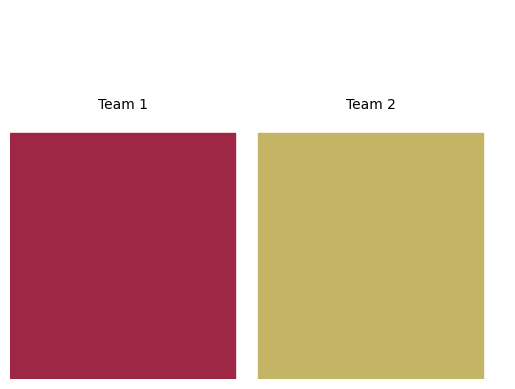

Player 1: Team1


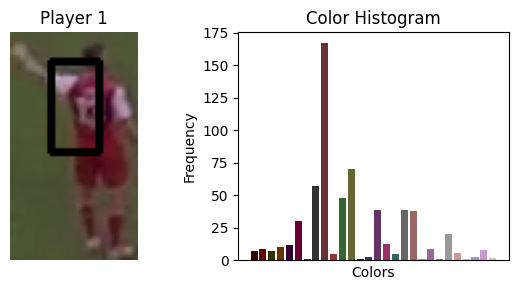

Player 2: Team2


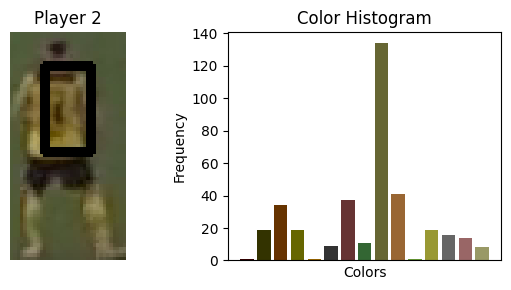

Player 3: Team1


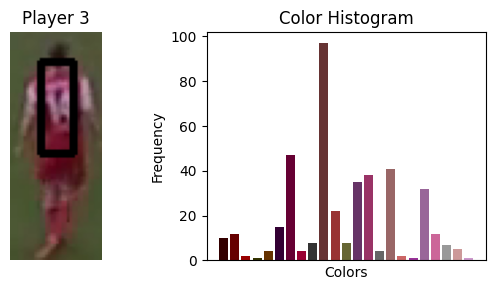

Player 4: Team1


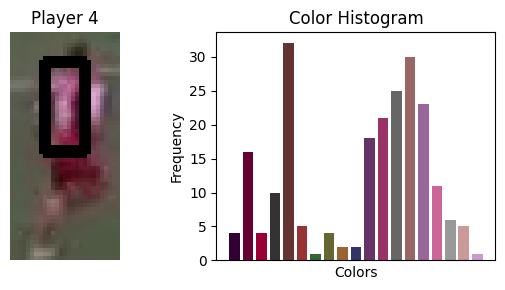

Player 5: Team1


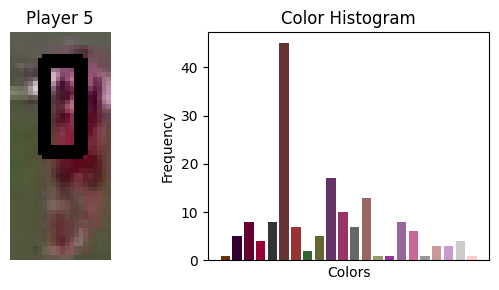

Player 6: Team2


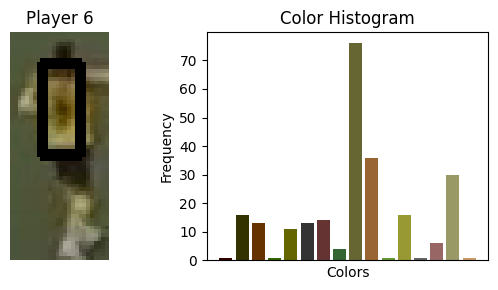

Player 7: Team2


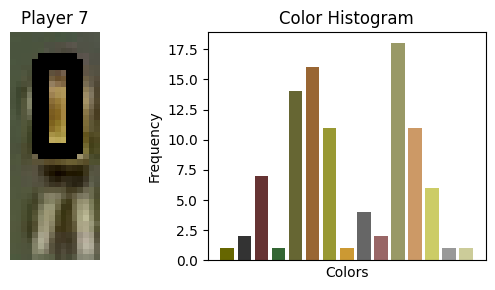

Player 8: Team1


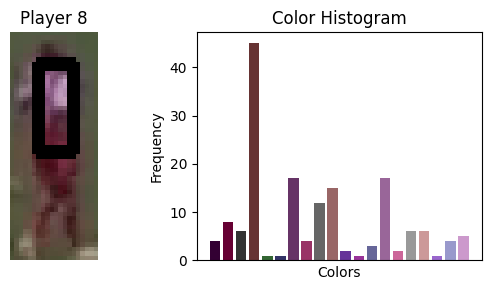

Player 9: Team2


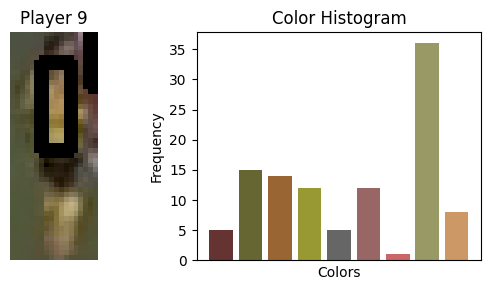

Player 10: Team2


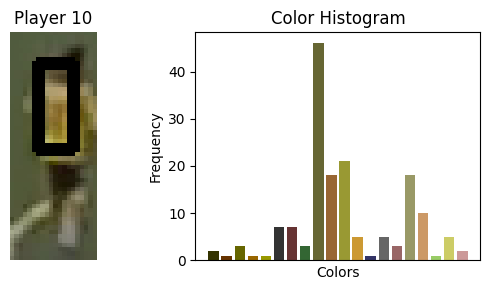

Player 11: Team1


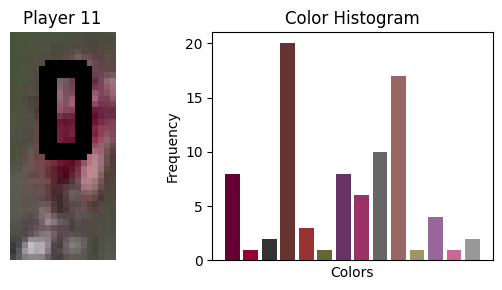

Player 12: Team2


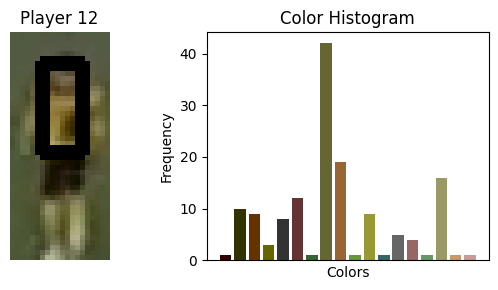

Player 13: Team1


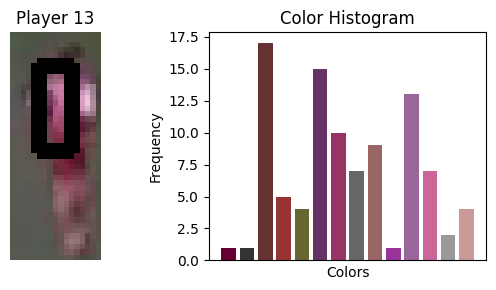

Player 14: Team2


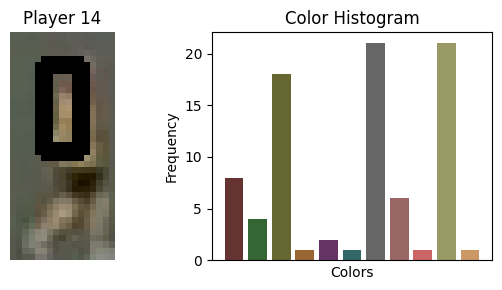

Player 15: Team2


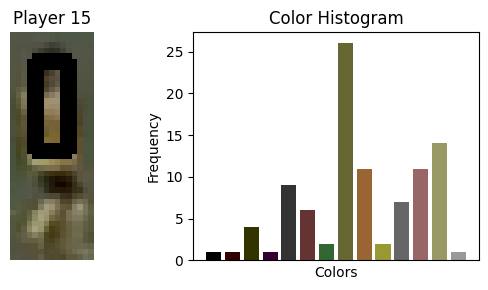

Player 16: Team1


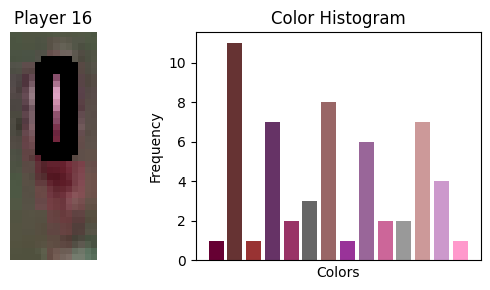

Player 17: Team2


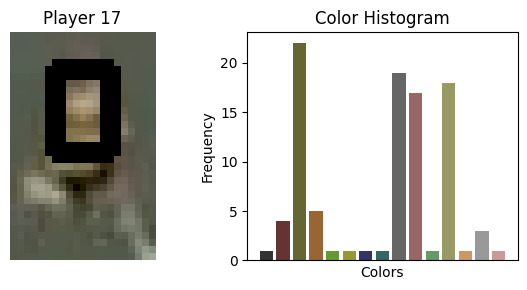

Player 18: Team2


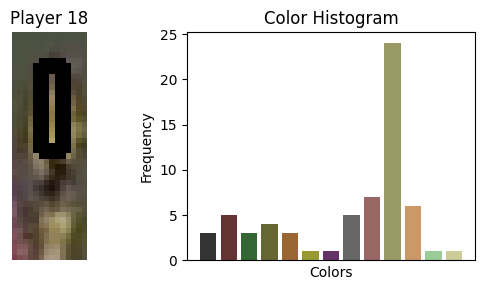

Player 19: Team1


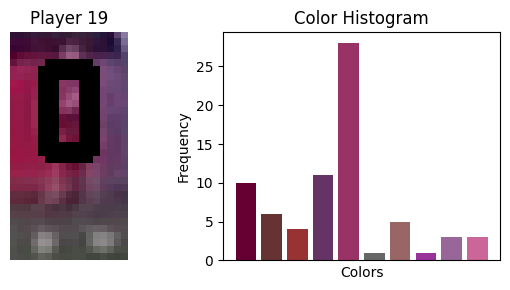

Player 20: Team1


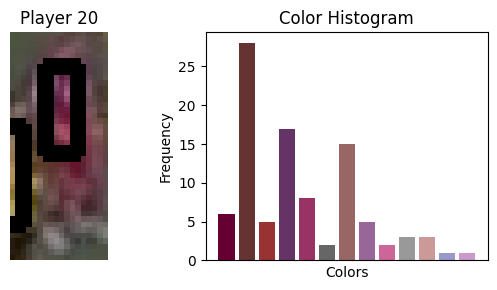

In [ ]:
import matplotlib.patches as patches

cropped_images = []

# Assuming 'frame_rgb' and 'results_players' are already defined as per your existing code
for player in players:
    bbox = player['box']  # Get bbox info (x,y,x,y)
    cropped_img = annotated_frame[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
    cropped_images.append(cropped_img)

# Assuming colors_list is defined and contains two BGR colors, for example:
# colors_list = [(0, 0, 255), (255, 0, 0)]  # BGR format

fig, ax = plt.subplots()

# Convert BGR to RGB and create a rectangle for each color
for i, color in enumerate(colors_list):
    # BGR to RGB conversion
    rgb_color = color[::-1]  # Reverse the color order
    rect = patches.Rectangle((i*1.1, 0), 1, 1, color=[c/255 for c in rgb_color])
    ax.add_patch(rect)
    ax.text(i*1.1 + 0.5, 1.1, f'Team {i+1}', ha='center')

# Set limits and remove axes for clarity
ax.set_xlim(0, len(colors_list)*1.1)
ax.set_ylim(0, 1.5)
ax.axis('off')

plt.show()

team_names = ["Team1", "Team2"]

for i, (img, palette) in enumerate(zip(cropped_images, obj_palette_list)):
    team = team_names[players_teams_list[i]]
    print(f'Player {i+1}: {team}')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

    # Display the cropped image
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.axis('off')
    ax1.set_title(f'Player {i+1}')

    # Prepare data for the histogram
    colors = [color for color, _ in palette]
    frequencies = [freq for _, freq in palette]

    # Display the histogram
    bars = ax2.bar(range(len(colors)), frequencies, color=[(r/255, g/255, b/255) for r, g, b in colors])
    ax2.set_title('Color Histogram')
    ax2.set_xlabel('Colors')
    ax2.set_ylabel('Frequency')
    ax2.set_xticks([])  # Hide x-ticks as they are not meaningful in this context

    plt.tight_layout()
    plt.show()

# Determine team color before tracking to improve tracking accuracy

In [ ]:
# Video frame dimensions
frame_width = 1920
frame_height = 1080

# Convert normalized box coordinates to absolute pixel values
def convert_normalized_box(box, width, height):
    xtl, ytl, xbr, ybr = box
    return [xtl * width, ytl * height, xbr * width, ybr * height]


# Adjust ball_data to use absolute pixel values
before_tracking_data_absolute = []
for frame in before_tracking_data:
    objects=[]
    for obj in frame:
        normalized_box = obj['box']
        absolute_box = convert_normalized_box(normalized_box, frame_width, frame_height)
        objects.append({'score': obj['score'], 'class': obj['class'], 'box': absolute_box})
    before_tracking_data_absolute.append(objects)

In [ ]:
vid = cv2.VideoCapture('./data/video/red_yellow.mp4')
current=0


while True:
    _, frame = vid.read()
    if frame is None:
        print('Completed')
        break

    frame_data=before_tracking_data_absolute[current]
    players=[obj for obj in frame_data if obj['class']=='player']

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)                                      # Convert frame to RGB
    obj_palette_list = []                                                                   # Initialize players color palette list
#    palette_interval = (0,5)                                                                # Color interval to extract from dominant colors palette (1rd to 5th color)
#    annotated_frame = frame.copy()                                                                 # Create annotated frame
    for player in players:
        bbox = player['box']                                                            # Get bbox info (x,y,x,y)
        obj_img = frame_rgb[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]       # Crop bbox out of the frame

        obj_img_w, obj_img_h = obj_img.shape[1], obj_img.shape[0]
        center_filter_x1 = np.max([(obj_img_w//2)-(obj_img_w//5), 1])
        center_filter_x2 = (obj_img_w//2)+(obj_img_w//5)
        center_filter_y1 = np.max([(obj_img_h//3)-(obj_img_h//5), 1])
        center_filter_y2 = (obj_img_h//3)+(obj_img_h//5)
        center_filter = obj_img[center_filter_y1:center_filter_y2,
                                center_filter_x1:center_filter_x2]



        obj_pil_img = Image.fromarray(np.uint8(center_filter))                          # Convert to pillow image

        reduced = obj_pil_img.convert("P", palette=Image.Palette.WEB)                   # Convert to web palette (216 colors)
        palette = reduced.getpalette()                                                  # Get palette as [r,g,b,r,g,b,...]
        palette = [palette[3*n:3*n+3] for n in range(256)]                              # Group 3 by 3 = [[r,g,b],[r,g,b],...]
        color_count = [(n, palette[m]) for n,m in reduced.getcolors()]                  # Create list of palette colors with their frequency
    #    RGB_df = pd.DataFrame(color_count, columns = ['cnt', 'RGB']).sort_values(       # Create dataframe based on defined palette interval
    #                          by = 'cnt', ascending = False).iloc[
    #                              palette_interval[0]:palette_interval[1],:]
    #    palette = list(RGB_df.RGB)                                                      # Convert palette to list (for faster processing)
    #    annotated_frame = cv2.rectangle(annotated_frame,                                # Add center filter bbox annotations
    #                                    (int(bbox[0])+center_filter_x1,
    #                                     int(bbox[1])+ center_filter_y1),
    #                                    (int(bbox[0])+center_filter_x2,
    #                                     int(bbox[1])+center_filter_y2), (0,0,0), 2)
        player_palette = []
        for count, color in color_count:
                player_palette.append((color, count))

        obj_palette_list.append(player_palette)

    ## Calculate distances between each color from every detected player color palette and the predefined teams colors
    players_distance_features = []

    # Loop over detected players' extracted color palettes
    for player_palette in obj_palette_list:
        palette_distance = []

        # Loop over colors in the player's palette (color is a tuple of (RGB, frequency))
        for color, freq in player_palette:
            color_lab = skimage.color.rgb2lab([i/255 for i in color])  # Convert color to L*a*b* space
            distance_list = []

            # Loop over predefined list of teams colors (now only two colors, one for each team)
            for c in color_list_lab:
                distance = skimage.color.deltaE_cie76(color_lab, c)  # Calculate Euclidean distance in Lab color space
                distance_list.append(distance)  # Update distance list for current color

            palette_distance.append((distance_list, freq))  # Update distance list for current palette with frequency

        players_distance_features.append(palette_distance)  # Update distance features list



    players_teams_list = []

    for player_palette in obj_palette_list:
        team_votes = [0, 0]  # Initialize votes for two teams

        for color, freq in player_palette:
            color_lab = skimage.color.rgb2lab([i/255 for i in color])  # Convert color to L*a*b* space
            distance_list = []

            # Calculate distances for the color
            for c in color_list_lab:
                distance = skimage.color.deltaE_cie76(color_lab, c)
                distance_list.append(distance)

            # Weighted voting
            team_idx = distance_list.index(min(distance_list))  # Closer team gets the vote
            team_votes[team_idx] += freq  # Weight vote by frequency of the color

        # Team with the highest weighted vote total is predicted
        predicted_team = team_votes.index(max(team_votes))
        players_teams_list.append(predicted_team)

    for i in range(len(players)):
        team=f"team{players_teams_list[i]+1}"
        players[i]['class']=team

    current+=1

Completed


In [ ]:
vid = cv2.VideoCapture('./data/video/red_yellow.mp4')

codec = cv2.VideoWriter_fourcc(*'mp4v')
vid_fps =int(vid.get(cv2.CAP_PROP_FPS))
vid_width,vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('./data/video/results-red_yellow8.mp4', codec, vid_fps, (vid_width, vid_height))

current=0

color_dict = {
"team1": (0, 0, 255),
"team2": (0, 255, 255),
"referee": (255,255,0),
"goalkeeper": (255, 0, 0),
"player": (255, 255, 0),
"ball": (255, 255, 255)
}

for frame in before_tracking_data_absolute:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    for obj in frame:
        bbox=obj['box']
        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])),color_dict[obj['class']], 2)

        cv2.putText(img,obj['class'], (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                    color_dict[obj['class']], 2)
    for obj in ball_data_absolute[current]:
        bbox=obj['box']
        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])),color_dict[obj['class']], 2)

        cv2.putText(img,obj['class'], (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                    color_dict[obj['class']], 2)


    current+=1
    out.write(img)

    #if cv2.waitKey(1) == ord('q'):
    #    break


vid.release()
out.release()

# Tactical map

In [ ]:
import cv2

key_points_list = [
    "TLC", "TRC", "TR6MC", "TL6MC", "TR6ML", "TL6ML",
    "TR18MC", "TL18MC", "TR18ML", "TL18ML", "TRArc", "TLArc",
    "RML", "RMC", "LMC", "LML", "BLC", "BRC", "BR6MC", "BL6MC",
    "BR6ML", "BL6ML", "BR18MC", "BL18MC", "BR18ML", "BL18ML",
    "BRArc", "BLArc"
]

new_key_points = {}  # Dictionary to store new key points
current_key_point = 0  # Index to keep track of current key point

# Function to handle mouse click events
def click_event(event, x, y, flags, param):
    global current_key_point, new_key_points

    if event == cv2.EVENT_LBUTTONDOWN and current_key_point < len(key_points_list):
        new_key_points[key_points_list[current_key_point]] = [x, y]
        print(f"Key Point {key_points_list[current_key_point]}: ({x}, {y})")
        current_key_point += 1
        if current_key_point < len(key_points_list):
            print(f"Click the position of {key_points_list[current_key_point]}")
        else:
            print("All key points have been defined.")
        cv2.circle(img, (x, y), radius=5, color=(0, 255, 0), thickness=-1)
        cv2.imshow('Tactical Map', img)

# Path to your new tactical map image
image_path = 'unnamed-chunk-2-1 (1).png'

# Load image
img = cv2.imread(image_path)
cv2.imshow('Tactical Map', img)

# Prompt for the first key point
print(f"Click the position of {key_points_list[current_key_point]}")

# Set the mouse callback function to 'click_event'
cv2.setMouseCallback('Tactical Map', click_event)

# Wait until a key is pressed and close the window
cv2.waitKey(0)
cv2.destroyAllWindows()

# Print the new key points dictionary
print("New Key Points:")
print(new_key_points)



Click the position of TLC
Key Point TLC: (100, 862)
Click the position of TRC
Key Point TRC: (101, 69)
Click the position of TR6MC
Key Point TR6MC: (159, 366)
Click the position of TL6MC
Key Point TL6MC: (159, 566)
Click the position of TR6ML
Key Point TR6ML: (100, 366)
Click the position of TL6ML
Key Point TL6ML: (100, 565)
Click the position of TR18MC
Key Point TR18MC: (278, 248)
Click the position of TL18MC
Key Point TL18MC: (278, 682)
Click the position of TR18ML
Key Point TR18ML: (101, 249)
Click the position of TL18ML
Key Point TL18ML: (100, 684)
Click the position of TRArc
Key Point TRArc: (280, 388)
Click the position of TLArc
Key Point TLArc: (279, 544)
Click the position of RML
Key Point RML: (694, 70)
Click the position of RMC
Key Point RMC: (696, 366)
Click the position of LMC
Key Point LMC: (694, 562)
Click the position of LML
Key Point LML: (696, 860)
Click the position of BLC
Key Point BLC: (1288, 862)
Click the position of BRC
Key Point BRC: (1287, 71)
Click the positio

In [ ]:
import json
new_key_points={'TLC': [100, 862], 'TRC': [101, 69], 'TR6MC': [159, 366], 'TL6MC': [159, 566], 'TR6ML': [100, 366], 'TL6ML': [100, 565], 'TR18MC': [278, 248], 'TL18MC': [278, 682], 'TR18ML': [101, 249], 'TL18ML': [100, 684], 'TRArc': [280, 388], 'TLArc': [279, 544], 'RML': [694, 70], 'RMC': [696, 366], 'LMC': [694, 562], 'LML': [696, 860], 'BLC': [1288, 862], 'BRC': [1287, 71], 'BR6MC': [1228, 367], 'BL6MC': [1228, 563], 'BR6ML': [1287, 365], 'BL6ML': [1286, 564], 'BR18MC': [1110, 249], 'BL18MC': [1110, 683], 'BR18ML': [1286, 248], 'BL18ML': [1287, 680], 'BRArc': [1109, 385], 'BLArc': [1110, 545]}
# Specify the filename for the JSON file
json_filename = 'updated_key_points.json'

# Write the dictionary to a JSON file
with open(json_filename, 'w') as file:
    json.dump(new_key_points, file, indent=4)

print(f"Key points saved to {json_filename}")

Key points saved to updated_key_points.json


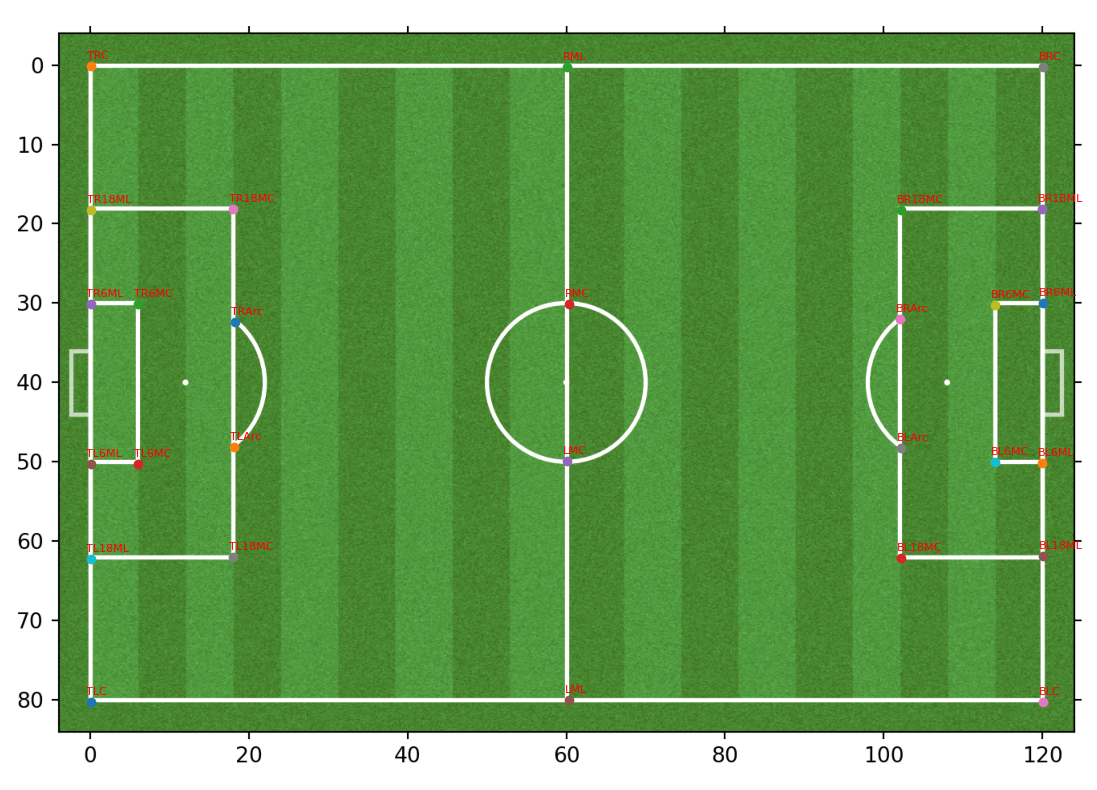

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json

# Load the JSON file with the key points
with open('updated_key_points.json', 'r') as file:
    key_points = json.load(file)

# Load the tactical map image
tactical_map = mpimg.imread('unnamed-chunk-2-1 (1).png')

# Create a figure with a larger size
plt.figure(figsize=(15, 10))  # Adjust the size as needed

# Plot the image
plt.imshow(tactical_map)
plt.axis('off')  # Optionally remove the axis

# Plot each key point and annotate
for label, coordinates in key_points.items():
    x, y = coordinates
    plt.scatter(x, y, marker='o')  # Plot the point
    plt.annotate(label, (x, y), textcoords="offset points", xytext=((-3),5),
                 ha='left', fontsize=8, color='red')

# Save the figure
plt.savefig('annotated_tactical_map2.jpg', format='jpg', dpi=300)

# Show the plot
plt.show()

In [ ]:
import xml.etree.ElementTree as ET

# Parse the XML file
tree = ET.parse('annotations 9.xml')
root = tree.getroot()

# Initialize arrays for results
keypoint_results = []

# Function to convert box attributes to a dictionary
def get_box_dict(box_element):
    return [
        float(box_element.get('xtl')),
        float(box_element.get('ytl')),
        float(box_element.get('xbr')),
        float(box_element.get('ybr'))]

# Process each track (object)
for track in root.findall('track'):
    label = track.get('label')

    # Dictionary to store boxes for each frame
    frames = {}

    # Process each box (appearance in a frame)
    for box in track.findall('box'):
        frame_num = int(box.get('frame'))
        outside = box.get('outside') == '1'

        if not outside:
            box_dict = get_box_dict(box)
            frames[frame_num] = {'box': box_dict, 'class': label}

    # Sort frames and add to the respective result array
    sorted_frames = sorted(frames.items())
    for frame_num, frame_data in sorted_frames:
        while len(keypoint_results) <= frame_num:
            keypoint_results.append([])
        keypoint_results[frame_num].append(frame_data)

In [ ]:
def calculate_central_coordinates(results, is_ball=False):
    central_pts = []
    for obj in results:
        # Convert from xyxy to xywh format
        x1, y1, x2, y2 = obj['box']
        x = x1
        y = y1
        w = x2 - x1
        h = y2 - y1

        # Calculate central coordinates based on object type
        if is_ball:  # For balls
            central_pts.append([x + w / 2, y + h / 2])
        else:  # For players, goalkeepers, and referees
            central_pts.append([x + w / 2, y + h])

    return np.array(central_pts)

In [ ]:
key_points = new_key_points
from sklearn.metrics import mean_squared_error
# Set keypoints average displacement tolerance level (in pixels) [set to -1 to always update homography matrix]
keypoints_displacement_mean_tol = 10
tac_map = cv2.imread('unnamed-chunk-2-1 (1).png')

player_pos=[]
other_pos=[]
ball_pos=[]

for frame_nbr in range (len(player_results)):

    detected_labels=[obj['class'] for obj in keypoint_results[frame_nbr]]
    detected_labels_src_pts_xyxy=[obj['box'] for obj in keypoint_results[frame_nbr]]
    detected_labels_src_pts= np.array([np.round([(x1 + x2) / 2, (y1 + y2) / 2]).astype(int) for x1, y1, x2, y2 in detected_labels_src_pts_xyxy])
    detected_labels_dst_pts=np.array([key_points[obj['class']] for obj in keypoint_results[frame_nbr]])

    ## Calculate Homography transformation matrix when more than 4 keypoints are detected
    if len(detected_labels) > 3:
        # Always calculate homography matrix on the first frame
        if frame_nbr > 0:
            # Determine common detected field keypoints between previous and current frames
            common_labels = set(detected_labels_prev) & set(detected_labels)
            # When at least 4 common keypoints are detected, determine if they are displaced on average beyond a certain tolerance level
            if len(common_labels) > 3:
                common_label_idx_prev = [detected_labels_prev.index(i) for i in common_labels]   # Get labels indexes of common detected keypoints from previous frame
                common_label_idx_curr = [detected_labels.index(i) for i in common_labels]        # Get labels indexes of common detected keypoints from current frame
                coor_common_label_prev = detected_labels_src_pts_prev[common_label_idx_prev]     # Get labels coordiantes of common detected keypoints from previous frame
                coor_common_label_curr = detected_labels_src_pts[common_label_idx_curr]          # Get labels coordiantes of common detected keypoints from current frame
                coor_error = mean_squared_error(coor_common_label_prev, coor_common_label_curr)  # Calculate error between previous and current common keypoints coordinates
                update_homography = coor_error > keypoints_displacement_mean_tol                 # Check if error surpassed the predefined tolerance level
            else:
                update_homography = True
        else:
            update_homography = True

        if  update_homography:
            h, mask = cv2.findHomography(detected_labels_src_pts,                   # Calculate homography matrix
                                          detected_labels_dst_pts)

        detected_labels_prev = detected_labels.copy()                               # Save current detected keypoint labels for next frame
        detected_labels_src_pts_prev = detected_labels_src_pts.copy()               # Save current detected keypoint coordiantes for next frame

        detected_player_src_pts = calculate_central_coordinates(player_results[frame_nbr])
        detected_other_src_pts = calculate_central_coordinates(other_results[frame_nbr])
        detected_ball_src_pts = calculate_central_coordinates(ball_results[frame_nbr], is_ball=True)

        # Transform players coordinates from frame plane to tactical map plance using the calculated Homography matrix
        pred_player_pts = []                                                           # Initialize players tactical map coordiantes list
        for pt in detected_player_src_pts:                                            # Loop over players frame coordiantes
            pt = np.append(np.array(pt), np.array([1]), axis=0)                     # Covert to homogeneous coordiantes
            dest_point = np.matmul(h, np.transpose(pt))                              # Apply homography transofrmation
            dest_point = dest_point/dest_point[2]                                   # Revert to 2D-coordiantes
            pred_player_pts.append(list(np.transpose(dest_point)[:2]))                 # Update players tactical map coordiantes list
        pred_player_pts = np.array(pred_player_pts)
        player_pos.append(pred_player_pts)

        pred_other_pts = []                                                           # Initialize players tactical map coordiantes list
        for pt in detected_other_src_pts:                                            # Loop over players frame coordiantes
            pt = np.append(np.array(pt), np.array([1]), axis=0)                     # Covert to homogeneous coordiantes
            dest_point = np.matmul(h, np.transpose(pt))                              # Apply homography transofrmation
            dest_point = dest_point/dest_point[2]                                   # Revert to 2D-coordiantes
            pred_other_pts.append(list(np.transpose(dest_point)[:2]))                 # Update players tactical map coordiantes list
        pred_other_pts = np.array(pred_other_pts)
        other_pos.append(pred_other_pts)

        pred_ball_pts = []                                                           # Initialize players tactical map coordiantes list
        for pt in detected_ball_src_pts:                                            # Loop over players frame coordiantes
            pt = np.append(np.array(pt), np.array([1]), axis=0)                     # Covert to homogeneous coordiantes
            dest_point = np.matmul(h, np.transpose(pt))                              # Apply homography transofrmation
            dest_point = dest_point/dest_point[2]                                   # Revert to 2D-coordiantes
            pred_ball_pts.append(list(np.transpose(dest_point)[:2]))                 # Update players tactical map coordiantes list
        pred_ball_pts = np.array(pred_ball_pts)
        ball_pos.append(pred_ball_pts)

In [ ]:
top_left=(67, 36)
bottom_right=(1321, 893)
new_width = bottom_right[0] - top_left[0]
new_height = bottom_right[1] - top_left[1]

# Ball representation
ball_image_path = 'pngegg.png'  # Path to the ball PNG image
ball_image = cv2.imread(ball_image_path, cv2.IMREAD_UNCHANGED)  # Load with alpha channel
ball_size = 20  # Diameter of the ball image, adjust as needed

tac_map = cv2.imread('unnamed-chunk-2-1 (1).png')



overlay_width = 400  # Adjust to your preference
overlay_height = int(new_height * (overlay_width / new_width))

# Setup the video capture
vid = cv2.VideoCapture('./data/video/results-red_green6.mp4')
vid_fps = int(vid.get(cv2.CAP_PROP_FPS))
vid_width, vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
pos_x = vid_width - overlay_width
pos_y = vid_height - overlay_height
# Setup the video writer with the size of the tactical map
codec = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('./data/video/results-red_green_tacmap_overlay.mp4', codec, vid_fps, (vid_width, vid_height))

frame_nbr=0

while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    detected_labels=[obj['class'] for obj in keypoint_results[frame_nbr]]
    if len(detected_labels) > 3:
        tac_map_copy = tac_map.copy()

        pred_player_pts=player_pos[frame_nbr]
        pred_other_pts=other_pos[frame_nbr]
        pred_ball_pts=ball_pos[frame_nbr]

        # Player representation
        player_radius = 15  # Adjust the radius as needed
        team1_color = (0, 0, 255)  # Red
        team2_color = (0, 255, 0)  # Yellow
        contour_color = (0, 0, 0)  # White color for contour
        contour_thickness = 2  # Thickness of the white contour

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7  # Adjust as needed based on your image size
        font_color = (0, 0, 0)  # White color for text
        font_thickness = 1

        for i, player in enumerate(pred_player_pts):
            player_center = (int(player[0]), int(player[1]))
            team_color = team1_color if player_results[frame_nbr][i]['class'] == 'team1' else team2_color

            # Draw the contour circle first (slightly larger)
            cv2.circle(tac_map_copy, player_center, player_radius + contour_thickness, contour_color, thickness=-1)

            # Then draw the filled circle with the team color
            cv2.circle(tac_map_copy, player_center, player_radius, team_color, -1)

            # Get the player's ID and convert it to string
            player_id = str(player_results[frame_nbr][i]['id'])

            # Calculate text size and position, then put the player's ID inside the circle
            text_size = cv2.getTextSize(player_id, font, font_scale, font_thickness)[0]
            text_x = player_center[0] - text_size[0] // 2
            text_y = player_center[1] + text_size[1] // 2
            cv2.putText(tac_map_copy, player_id, (text_x, text_y), font, font_scale, font_color, font_thickness)

        other_radius = 15  # Adjust the radius as needed
        ref_color = (255, 255, 0)
        gk_color = (255, 0, 0)
        contour_color = (255, 255, 255)  # White color for contour
        contour_thickness = 2  # Thickness of the white contour

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7  # Adjust as needed based on your image size
        font_color = (0, 0, 0)  # White color for text
        font_thickness = 1

        for i, other in enumerate(pred_other_pts):
            other_center = (int(other[0]), int(other[1]))
            team_color = ref_color if other_results[frame_nbr][i]['class'] == 'referee' else gk_color

            # Draw the contour circle first (slightly larger)
            cv2.circle(tac_map_copy, other_center, other_radius + contour_thickness, contour_color, thickness=-1)

            # Then draw the filled circle with the team color
            cv2.circle(tac_map_copy, other_center, other_radius, team_color, -1)

            # Get the player's ID and convert it to string
            id = 'R' if other_results[frame_nbr][i]['class'] == 'referee' else 'GK'

            # Calculate text size and position, then put the player's ID inside the circle
            text_size = cv2.getTextSize(id, font, font_scale, font_thickness)[0]
            text_x = other_center[0] - text_size[0] // 2
            text_y = other_center[1] + text_size[1] // 2
            cv2.putText(tac_map_copy, id, (text_x, text_y), font, font_scale, font_color, font_thickness)




        for ball in pred_ball_pts:  # Assuming pred_ball_pts is a list of [x, y] tuples
            # Calculate the top-left corner for overlay
            x, y = int(ball[0] - ball_size // 2), int(ball[1] - ball_size // 2)

            # Resize the ball image
            ball_resized = cv2.resize(ball_image, (ball_size, ball_size))

            # Handle transparency if the ball image has an alpha channel
            if ball_resized.shape[2] == 4:  # 4 channels: RGBA
                alpha_mask = ball_resized[:, :, 3] / 255.0  # Normalized alpha channel
                alpha_inv = 1.0 - alpha_mask

                for c in range(0, 3):  # RGB channels
                    tac_map_copy[y:y+ball_size, x:x+ball_size, c] = \
                        alpha_inv * tac_map_copy[y:y+ball_size, x:x+ball_size, c] + \
                        alpha_mask * ball_resized[:, :, c]
            else:
                # If no alpha channel, overlay directly
                tac_map_copy[y:y+ball_size, x:x+ball_size] = ball_resized

    frame_nbr+=1

    cropped_tac_map = tac_map_copy[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

    tac_map_resized=cv2.resize(cropped_tac_map, (overlay_width, overlay_height))
    img[pos_y:pos_y + overlay_height, pos_x:pos_x + overlay_width] = tac_map_resized

    out.write(img)

vid.release()
out.release()

Completed


In [ ]:
vid = cv2.VideoCapture('./data/video/red_green.mp4')

codec = cv2.VideoWriter_fourcc(*'mp4v')
vid_fps =int(vid.get(cv2.CAP_PROP_FPS))
vid_width,vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('./data/video/results-red_green_keypoints.mp4', codec, vid_fps, (vid_width, vid_height))

current=0

for frame in keypoint_results:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    for obj in frame:
        bbox=obj['box']
        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])),(255,255,255), 2)

        cv2.putText(img,obj['class'], (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                    (255,255,255), 2)

    current+=1
    out.write(img)

    #if cv2.waitKey(1) == ord('q'):
    #    break


vid.release()
out.release()